In [141]:
import cv2
import numpy as np
import pandas as pd
import os
import sys
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
import keras_tuner as kt
from sklearn.metrics import classification_report
import shutil
from os import path
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image_dataset_from_directory
from keras.preprocessing.image import ImageDataGenerator

# path variables to access files
root = os.getcwd()
binary_root = os.path.join(root, "binary_task")
multiclass_root = os.path.join(root, "multiclass_task")

### Load dataframe

In [2]:
main_data = pd.read_csv("data_labels_mainData.csv")
extra_data = pd.read_csv("data_labels_extraData.csv")

### split data into different folders for different cell types

In [27]:
root = os.getcwd()
source_dir = os.path.join(root, "patch_images")

for i, row in main_data.iterrows():
    image_name = row["ImageName"]
    cell_name = row["cellTypeName"]
    is_cancer = str(row["isCancerous"])

#     new_folder_multi = os.path.join(root,"multiclass_task", cell_name)
    new_folder_bin = os.path.join(root,"binary_task", is_cancer)

#     os.makedirs(new_folder_multi, exist_ok=True)
    os.makedirs(new_folder_bin, exist_ok=True)

    source = os.path.join(source_dir, image_name)

#     dest_multi = os.path.join(root, "multiclass_task",cell_name)
    dest_bin = os.path.join(root,"binary_task", is_cancer)

#     go = shutil.copy(source,dest_multi)
    go = shutil.copy(source, dest_bin)

### Add training data for cancerous classification from extra dataset 

In [15]:
root = os.getcwd()
source_dir = os.path.join(root, "patch_images")

for i, row in extra_data.iterrows():
    image_name = row["ImageName"]
    is_cancer = str(row["isCancerous"])

    new_folder_bin = os.path.join(root, "binary_task",is_cancer)

    os.makedirs(new_folder_bin, exist_ok=True)

    source = os.path.join(source_dir, image_name)

    dest_bin = os.path.join(root, is_cancer)

    go = shutil.copy(source, dest_bin)

### Get data from splitted folder

In [3]:
root = os.getcwd()
source_dir = os.path.join(root, "patch_images")

# method get data for binary task (task 1)
def cancerous_classify_data():    
    images = list()
    labels = list()
    
    for label in [0, 1]:
        # get image directory
        img_dir = os.path.join(root, "binary_task",f"{label}")
        
        for img in os.listdir(img_dir):
            img = cv2.imread(os.path.join(img_dir, img))
            # resize to 0-1 for faster computation
            resized = img / 255
            images.append(resized)
            labels.append(label)
        
    return (images, labels)

all_class = ["epithelial", "fibroblast", "inflammatory", "others"]

# method get data for multiclass task (task 2)
def celltype_classify_data(class_list):    
    images = list()
    labels = list()
    
    for i, label in enumerate(class_list):
        # get image directory
        img_dir = os.path.join(root, "multiclass_task", f"{label}")
        
        for img in os.listdir(img_dir):
            img = cv2.imread(os.path.join(img_dir, img))
            # resize to 0-1 for faster computation
            resized = img / 255
            images.append(resized)
            labels.append(i)
        
    return (images, labels)

### Classification report

In [146]:
def multiclass_classification_report(y_test, prediction):
    """
        Method to generate sklearn classification report with CNN multiclass output
    """
    
    encoded_pred = list()
    # convert each CNN output (sparse categorial) to class
    for pred in prediction:
        encoded_pred.append(np.argmax(pred))

    encoded_pred = np.array(encoded_pred)
    print(classification_report(y_test, encoded_pred))
    
def binary_classification_report(y_test, prediction):
    """
        Method to generate sklearn classification report with CNN binary output
    """
    encoded_pred = list()
    # convert each CNN output (sparse categorial) to class
    for pred in prediction:
        encoded_pred.append(round(pred[0]))

    encoded_pred = np.array(encoded_pred)
    print(classification_report(y_test, encoded_pred))

## I) Task 1 - Binary classification

### Load binary data

In [165]:
# data being used
images, cancer_label = cancerous_classify_data()

# change to numpy
images, cancer_label = np.array(images), np.array(cancer_label)
print(images.shape)
print(cancer_label.shape)

# generate train, validation and test set
x_train_val, x_test, y_train_val, y_test = train_test_split(
    images, cancer_label, test_size=0.2
)
x_train, x_val, y_train, y_val = train_test_split(
    x_train_val, y_train_val, test_size=0.25
)

(9896, 27, 27, 3)
(9896,)


### Base CNN model

In [166]:
def get_model():
    model = tf.keras.Sequential()
    # First convo-pooling
    # Convolutional layers (filter the image with a kernel)
    model.add(tf.keras.layers.Conv2D(32, (3, 3), activation="relu", input_shape=[27, 27, 3]))
    # Max-pooling layers (reduce the size of the image by choosing max pixel at certain area)
    model.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2)))
    # Flatten input
    model.add(tf.keras.layers.Flatten())

    model.add(tf.keras.layers.Dense(128, activation="relu"))
    model.add(tf.keras.layers.Dense(32, activation="relu"))
    # Output layer
    model.add(tf.keras.layers.Dense(1, activation="sigmoid"))
    # Compile model
    model.compile(optimizer="adam",
                  loss="binary_crossentropy",
                  metrics=["accuracy", "AUC"])
    return model

binary_model = get_model()
binary_model.fit(x_train, y_train, epochs=10, validation_data=(x_val, y_val))

Epoch 1/10


2022-05-07 21:06:32.680362: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


186/186 [==============================] - ETA: 0s - loss: 0.4300 - accuracy: 0.8021 - auc: 0.8813

2022-05-07 21:06:35.198441: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


186/186 [==============================] - 3s 15ms/step - loss: 0.4300 - accuracy: 0.8021 - auc: 0.8813 - val_loss: 0.3503 - val_accuracy: 0.8302 - val_auc: 0.9477
Epoch 2/10
186/186 [==============================] - 2s 11ms/step - loss: 0.3116 - accuracy: 0.8683 - auc: 0.9385 - val_loss: 0.3070 - val_accuracy: 0.8676 - val_auc: 0.9543
Epoch 3/10
186/186 [==============================] - 2s 11ms/step - loss: 0.3108 - accuracy: 0.8725 - auc: 0.9383 - val_loss: 0.3687 - val_accuracy: 0.8403 - val_auc: 0.9555
Epoch 4/10
186/186 [==============================] - 2s 11ms/step - loss: 0.2911 - accuracy: 0.8786 - auc: 0.9461 - val_loss: 0.3083 - val_accuracy: 0.8696 - val_auc: 0.9578
Epoch 5/10
186/186 [==============================] - 2s 11ms/step - loss: 0.2902 - accuracy: 0.8792 - auc: 0.9466 - val_loss: 0.2641 - val_accuracy: 0.8924 - val_auc: 0.9578
Epoch 6/10
186/186 [==============================] - 2s 11ms/step - loss: 0.2617 - accuracy: 0.8924 - auc: 0.9567 - val_loss: 0.3209 - 

In [167]:
binary_pred = binary_model.predict(x_test)
binary_classification_report(y_test, binary_pred)

              precision    recall  f1-score   support

           0       0.90      0.90      0.90      1160
           1       0.86      0.86      0.86       820

    accuracy                           0.88      1980
   macro avg       0.88      0.88      0.88      1980
weighted avg       0.88      0.88      0.88      1980



2022-05-07 21:06:55.036117: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


### CNN with ZCA whitening

In [168]:
# get zca whitening data
datagen = ImageDataGenerator(
    zca_whitening=True,
)
datagen.fit(images)

zca_aug_train = datagen.flow(x_train, y_train, shuffle=True)
zca_aug_val = datagen.flow(x_val, y_val, shuffle=True)
zca_aug_test = datagen.flow(x_test, y_test, shuffle=True)

zca_binary = get_model()
zca_binary.fit(zca_aug_train, epochs=10, validation_data=zca_aug_val)

/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow/lib/python3.9/site-packages/keras_preprocessing/image/image_data_generator.py:337: UserWarning: This ImageDataGenerator specifies `zca_whitening`, which overrides setting of `featurewise_center`.
  warnings.warn('This ImageDataGenerator specifies '


Epoch 1/10


2022-05-07 21:06:59.930672: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


186/186 [==============================] - ETA: 0s - loss: 0.4450 - accuracy: 0.7852 - auc: 0.8671

2022-05-07 21:07:15.732767: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


186/186 [==============================] - 20s 106ms/step - loss: 0.4450 - accuracy: 0.7852 - auc: 0.8671 - val_loss: 0.3196 - val_accuracy: 0.8636 - val_auc: 0.9387
Epoch 2/10
186/186 [==============================] - 20s 107ms/step - loss: 0.2857 - accuracy: 0.8821 - auc: 0.9480 - val_loss: 0.3155 - val_accuracy: 0.8732 - val_auc: 0.9443
Epoch 3/10
186/186 [==============================] - 19s 102ms/step - loss: 0.2349 - accuracy: 0.9062 - auc: 0.9649 - val_loss: 0.3167 - val_accuracy: 0.8615 - val_auc: 0.9430
Epoch 4/10
186/186 [==============================] - 20s 109ms/step - loss: 0.2174 - accuracy: 0.9121 - auc: 0.9698 - val_loss: 0.3205 - val_accuracy: 0.8671 - val_auc: 0.9423
Epoch 5/10
186/186 [==============================] - 20s 107ms/step - loss: 0.1769 - accuracy: 0.9308 - auc: 0.9804 - val_loss: 0.3338 - val_accuracy: 0.8631 - val_auc: 0.9381
Epoch 6/10
186/186 [==============================] - 19s 104ms/step - loss: 0.1703 - accuracy: 0.9355 - auc: 0.9813 - val_los

In [179]:
aug_x, aug_y = zca_aug_test.next()
zca_binary_pred = zca_binary.predict(aug_x)

binary_classification_report(aug_y, zca_binary_pred)

              precision    recall  f1-score   support

           0       0.90      0.95      0.92        19
           1       0.92      0.85      0.88        13

    accuracy                           0.91        32
   macro avg       0.91      0.90      0.90        32
weighted avg       0.91      0.91      0.91        32



2022-05-07 21:17:04.583017: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


### CNN with rotation

In [170]:
# get rotation data
datagen = ImageDataGenerator(
    rotation_range=45,
)
datagen.fit(images)

aug_train = datagen.flow(x_train, y_train, shuffle=True)
aug_val = datagen.flow(x_val, y_val, shuffle=True)
aug_test = datagen.flow(x_test, y_test, shuffle=True)

rotation_binary = get_model()
rotation_binary.fit(aug_train, epochs=10, validation_data=aug_val)

Epoch 1/10


2022-05-07 21:10:15.130412: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


181/186 [============================>.] - ETA: 0s - loss: 0.4712 - accuracy: 0.7724 - auc: 0.8526

2022-05-07 21:10:17.661288: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


186/186 [==============================] - 3s 16ms/step - loss: 0.4696 - accuracy: 0.7733 - auc: 0.8538 - val_loss: 0.4608 - val_accuracy: 0.7772 - val_auc: 0.9441
Epoch 2/10
186/186 [==============================] - 2s 12ms/step - loss: 0.3332 - accuracy: 0.8615 - auc: 0.9292 - val_loss: 0.2932 - val_accuracy: 0.8742 - val_auc: 0.9481
Epoch 3/10
186/186 [==============================] - 2s 11ms/step - loss: 0.3280 - accuracy: 0.8604 - auc: 0.9315 - val_loss: 0.3173 - val_accuracy: 0.8686 - val_auc: 0.9490
Epoch 4/10
186/186 [==============================] - 2s 11ms/step - loss: 0.3114 - accuracy: 0.8678 - auc: 0.9383 - val_loss: 0.3080 - val_accuracy: 0.8732 - val_auc: 0.9517
Epoch 5/10
186/186 [==============================] - 2s 11ms/step - loss: 0.3049 - accuracy: 0.8717 - auc: 0.9410 - val_loss: 0.3060 - val_accuracy: 0.8686 - val_auc: 0.9530
Epoch 6/10
186/186 [==============================] - 2s 11ms/step - loss: 0.2989 - accuracy: 0.8757 - auc: 0.9431 - val_loss: 0.2872 - 

In [171]:
aug_x, aug_y = aug_test.next()
rotation_pred = rotation_binary.predict(aug_x)
binary_classification_report(aug_y, rotation_pred)

              precision    recall  f1-score   support

           0       0.86      0.95      0.90        20
           1       0.90      0.75      0.82        12

    accuracy                           0.88        32
   macro avg       0.88      0.85      0.86        32
weighted avg       0.88      0.88      0.87        32



2022-05-07 21:10:37.606109: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


### Tune CNN model

**Parameters that affect the output of models:**
- Size of kernel of Convolution/Pooling Layers
- Strides of Convolution/Pooling Layers
- Activation function

**Other aspects that would affect the output of models**
- Number of Convolution/Pooling layers
- Number of hidden layer

**Method of tuning**: for this problem, the tuning being applied is RandomSearch as there are many combinations to adjust the model. The tuning progress would be carried out both manually and by using keras tuner

In [172]:
def cnn_tuner(hp):
    model = tf.keras.Sequential()

    for i in range(hp.Int(f'no_cnn', 1, 4, step=1)):
        # Convolutional layers (filter the image with a kernel)
        model.add(tf.keras.layers.Conv2D(hp.Int(f'convo_filter_{i}', 16, 128, step=16), (3, 3), strides=1,activation=hp.Choice(f"activation_convo_{i}", ["relu", "sigmoid", "softmax", "tanh"]), input_shape=[27, 27, 3]))
        # Max-pooling layers (reduce the size of the image by choosing max pixel at certain area)
        model.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=1,))
        
    # Flatten input
    model.add(tf.keras.layers.Flatten())

    # hidden layers
    for i in range(hp.Int('layers_no', 1, 4)):
        model.add(tf.keras.layers.Dense(hp.Int(f'hidden_layer_{i}', 32, 256, step=32), activation=hp.Choice(f"activation_hidden_{i}", ["relu", "sigmoid", "softmax", "tanh"])))
        
    # output layer
    model.add(tf.keras.layers.Dense(1, activation="sigmoid"))   
    # Compile model
    model.compile(optimizer="adam",
                  loss="binary_crossentropy",
                  metrics=["accuracy", "AUC"])
    
    return model
              
tuner = kt.RandomSearch(cnn_tuner, objective="val_accuracy", max_trials=5)

tuner.search(x_train, y_train, epochs=5, validation_data=(x_val, y_val))
best_model = tuner.get_best_models()[0]

INFO:tensorflow:Reloading Oracle from existing project ./untitled_project/oracle.json
INFO:tensorflow:Reloading Tuner from ./untitled_project/tuner0.json
INFO:tensorflow:Oracle triggered exit


In [173]:
# print(f"Best Convolution filter: {tuner.get_best_hyperparameters()[0].get('convo_filter')}")
print(f"Best number of CNN layer: {tuner.get_best_hyperparameters()[0].get('no_cnn')}")
print(f"Best number of hidden layer: {tuner.get_best_hyperparameters()[0].get('layers_no')}")

for i in range(tuner.get_best_hyperparameters()[0].get('no_cnn')):
    print(f"Best filter in CNN layer {i}: {tuner.get_best_hyperparameters()[0].get(f'convo_filter_{i}')}")
    print(f"Best activation in CNN layer {i}: {tuner.get_best_hyperparameters()[0].get(f'activation_convo_{i}')}")

for i in range(tuner.get_best_hyperparameters()[0].get('layers_no')):
    print(f"Best nodes in hidden layer {i}: {tuner.get_best_hyperparameters()[0].get(f'hidden_layer_{i}')}")
    print(f"Best activation in hidden layer {i}: {tuner.get_best_hyperparameters()[0].get(f'activation_hidden_{i}')}")

Best number of CNN layer: 4
Best number of hidden layer: 2
Best filter in CNN layer 0: 32
Best activation in CNN layer 0: relu
Best filter in CNN layer 1: 48
Best activation in CNN layer 1: relu
Best filter in CNN layer 2: 16
Best activation in CNN layer 2: relu
Best filter in CNN layer 3: 16
Best activation in CNN layer 3: relu
Best nodes in hidden layer 0: 192
Best activation in hidden layer 0: relu
Best nodes in hidden layer 1: 128
Best activation in hidden layer 1: sigmoid


In [174]:
best_model.fit(x_train, y_train, epochs=10, validation_data=(x_test, y_test))

Epoch 1/10


2022-05-07 21:10:39.267139: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


186/186 [==============================] - ETA: 0s - loss: 0.2843 - accuracy: 0.8807 - auc: 0.9489

2022-05-07 21:10:43.089026: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


186/186 [==============================] - 5s 23ms/step - loss: 0.2843 - accuracy: 0.8807 - auc: 0.9489 - val_loss: 0.3276 - val_accuracy: 0.8581 - val_auc: 0.9467
Epoch 2/10
186/186 [==============================] - 3s 16ms/step - loss: 0.2809 - accuracy: 0.8841 - auc: 0.9499 - val_loss: 0.3613 - val_accuracy: 0.8444 - val_auc: 0.9490
Epoch 3/10
186/186 [==============================] - 3s 15ms/step - loss: 0.2823 - accuracy: 0.8851 - auc: 0.9493 - val_loss: 0.2887 - val_accuracy: 0.8753 - val_auc: 0.9511
Epoch 4/10
186/186 [==============================] - 3s 15ms/step - loss: 0.2687 - accuracy: 0.8856 - auc: 0.9542 - val_loss: 0.3014 - val_accuracy: 0.8737 - val_auc: 0.9557
Epoch 5/10
186/186 [==============================] - 3s 15ms/step - loss: 0.2834 - accuracy: 0.8786 - auc: 0.9492 - val_loss: 0.2581 - val_accuracy: 0.8995 - val_auc: 0.9578
Epoch 6/10
186/186 [==============================] - 3s 15ms/step - loss: 0.2731 - accuracy: 0.8866 - auc: 0.9528 - val_loss: 0.2661 - 

In [175]:
binary_tuned_pred = best_model.predict(x_test)
binary_classification_report(y_test, binary_tuned_pred)

2022-05-07 21:11:09.286824: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


              precision    recall  f1-score   support

           0       0.92      0.88      0.90      1160
           1       0.84      0.90      0.87       820

    accuracy                           0.89      1980
   macro avg       0.88      0.89      0.88      1980
weighted avg       0.89      0.89      0.89      1980



### Ensemble model

In [195]:
# intialize and train sub-models
def get_sub_model():
    # number of sub models
    nets = 5
    sub_models = [0]*nets
    model_path = os.path.join(root, "binary_submodels")
    
    if not path.exists(model_path) or len(os.listdir(model_path))!=nets:
        for i in range(nets):
            model = get_model()
            # fit sub_model with train and test data
            model.fit(x_train, y_train, epochs=5, validation_data=(x_val, y_val))
            # save fitted sub_model to model list
            sub_models[i] = model
            
            # new file dir
            new_dir = os.path.join(model_path, f'submodel_{i}.h5')
            # save model to file
            model.save(new_dir)
        return sub_models
    else:
        for i in range(nets):
            sub_models[i]=keras.models.load_model(os.path.join(model_path, f'submodel_{i}.h5'))
        
        return sub_models
    
sub_models = get_sub_model()

In [199]:
# method to get output from submodels to feed meta_learner
# shape of dataset would be (no rows of OG dataset, [no output of sub model * no sub model])
def get_ensembled_x(x):
    ensembled_data = None
    for sub_model in sub_models:
        prediction = sub_model.predict(x)
        
        # stack prediction of sub model to ensembled data
        if ensembled_data is None:
            ensembled_data = prediction
        else:
            ensembled_data = np.dstack((ensembled_data, prediction))
            
    # ensemble data initially shape iz (no_col, no submodels, no classes)        
    # reshape to (no_col, no submodels*no classes)
    ensembled_data = ensembled_data.reshape(ensembled_data.shape[0], ensembled_data.shape[1]*ensembled_data.shape[2])
    return ensembled_data

def get_meta_learner():
    model = tf.keras.Sequential()
    # Flatten input
    model.add(tf.keras.layers.Flatten())
    # Hidden layers
    model.add(tf.keras.layers.Dense(256, activation="tanh"))
    model.add(tf.keras.layers.Dense(128, activation="softmax"))
    model.add(tf.keras.layers.Dense(32, activation="relu"))
    # Output layer
    model.add(tf.keras.layers.Dense(1, activation="sigmoid"))
    # Compile model
    model.compile(optimizer="adam",
                  loss="binary_crossentropy",
                  metrics=["accuracy", "AUC"])
    
    # get train ensembled data
    ensembled_x = get_ensembled_x(x_train)
    
    model.fit(ensembled_x, y_train, epochs=10)
    return model 

In [200]:
# evaluate with ensembled CNN model
# get test data
ensembled_x_test = get_ensembled_x(x_test)
# get trained ensemble model
ensembled_model = get_meta_learner()

Epoch 1/10


2022-05-07 21:24:04.286759: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


248/248 [==============================] - 3s 9ms/step - loss: 0.4300 - accuracy: 0.8643 - auc: 0.9162
Epoch 2/10
248/248 [==============================] - 2s 9ms/step - loss: 0.2533 - accuracy: 0.8996 - auc: 0.9598
Epoch 3/10
248/248 [==============================] - 2s 8ms/step - loss: 0.2489 - accuracy: 0.8968 - auc: 0.9613
Epoch 4/10
248/248 [==============================] - 2s 9ms/step - loss: 0.2470 - accuracy: 0.9007 - auc: 0.9620
Epoch 5/10
248/248 [==============================] - 2s 8ms/step - loss: 0.2454 - accuracy: 0.9005 - auc: 0.9621
Epoch 6/10
248/248 [==============================] - 2s 9ms/step - loss: 0.2456 - accuracy: 0.8996 - auc: 0.9619
Epoch 7/10
248/248 [==============================] - 2s 9ms/step - loss: 0.2447 - accuracy: 0.8998 - auc: 0.9623
Epoch 8/10
248/248 [==============================] - 2s 9ms/step - loss: 0.2438 - accuracy: 0.9002 - auc: 0.9623
Epoch 9/10
248/248 [==============================] - 2s 9ms/step - loss: 0.2436 - accuracy: 0.8982

2022-05-07 21:24:26.392564: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


62/62 [==============================] - 1s 9ms/step - loss: 0.2392 - accuracy: 0.9051 - auc: 0.9641


[0.2392214834690094, 0.90505051612854, 0.9640738368034363]

In [202]:
# evaluate
ensemble_pred = ensembled_model.predict(ensembled_x_test)
binary_classification_report(y_test, ensemble_pred)

              precision    recall  f1-score   support

           0       0.91      0.94      0.92      1177
           1       0.90      0.86      0.88       803

    accuracy                           0.91      1980
   macro avg       0.90      0.90      0.90      1980
weighted avg       0.91      0.91      0.90      1980



## II) Task 2 - Multiclasses classification


### Load data for multiclasses

In [301]:
all_class = ["epithelial", "fibroblast", "inflammatory", "others"]


cell_img, celltype_label = celltype_classify_data(all_class)
cell_img, celltype_label = np.array(cell_img), np.array(celltype_label)

x_train_val, x_test, y_train_val, y_test = train_test_split(
    cell_img, celltype_label, test_size=0.2
)

x_train, x_val, y_train, y_val = train_test_split(
    x_train_val, y_train_val, test_size=0.25
)

### Base model for multiclass  

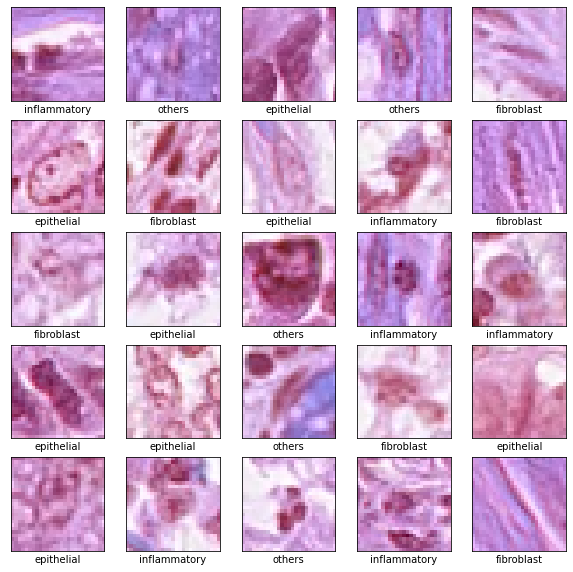

Epoch 1/15


2022-05-07 21:27:34.289126: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


198/198 [==============================] - ETA: 0s - loss: 1.0832 - accuracy: 0.5540

2022-05-07 21:27:37.599745: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


198/198 [==============================] - 4s 18ms/step - loss: 1.0832 - accuracy: 0.5540 - val_loss: 0.8623 - val_accuracy: 0.6540
Epoch 2/15
198/198 [==============================] - 3s 15ms/step - loss: 0.8638 - accuracy: 0.6622 - val_loss: 0.7673 - val_accuracy: 0.7058
Epoch 3/15
198/198 [==============================] - 3s 15ms/step - loss: 0.8277 - accuracy: 0.6788 - val_loss: 0.7259 - val_accuracy: 0.7191
Epoch 4/15
198/198 [==============================] - 3s 15ms/step - loss: 0.7876 - accuracy: 0.6952 - val_loss: 0.6952 - val_accuracy: 0.7292
Epoch 5/15
198/198 [==============================] - 3s 15ms/step - loss: 0.7770 - accuracy: 0.6982 - val_loss: 0.7239 - val_accuracy: 0.7292
Epoch 6/15
198/198 [==============================] - 3s 15ms/step - loss: 0.6956 - accuracy: 0.7206 - val_loss: 0.7465 - val_accuracy: 0.7008
Epoch 7/15
198/198 [==============================] - 3s 15ms/step - loss: 0.6767 - accuracy: 0.7339 - val_loss: 0.6681 - val_accuracy: 0.7443
Epoch 8/15

In [204]:

# print first 25 images
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i], cmap=plt.cm.binary)
    plt.xlabel(all_class[y_train[i]])
plt.show()

def get_multiclass_model():
    model = tf.keras.Sequential()
    # First convo-pooling
    # Convolutional layers (filter the image with a kernel)
    model.add(tf.keras.layers.Conv2D(64, (3, 3), strides=1,activation="relu", input_shape=[27, 27, 3]))
    # Max-pooling layers (reduce the size of the image by choosing max pixel at certain area)
    model.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=1))
    
    # Second convo-pooling
    # Convolutional layers (filter the image with a kernel)
    model.add(tf.keras.layers.Conv2D(64, (3, 3),strides=1, activation="relu"))
    # Max-pooling layers (reduce the size of the image by choosing max pixel at certain area)
    model.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2),strides=1))
    
    # Flatten input
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(256, activation="relu"))
    model.add(tf.keras.layers.Dense(128, activation="relu"))
    model.add(tf.keras.layers.Dense(32, activation="relu"))
    # Output layer
    model.add(tf.keras.layers.Dense(4, activation="softmax"))
    # Compile model 
    model.compile(optimizer="adam",
                  loss="sparse_categorical_crossentropy",
                  metrics=["accuracy"])
    
    return model

multi_model = get_multiclass_model()
multi_model.fit(x_train, y_train, epochs=15, validation_data=(x_val, y_val))

In [205]:
multi_pred = multi_model.predict(x_test)
multiclass_classification_report(y_test, multi_pred)

2022-05-07 21:28:39.283254: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


              precision    recall  f1-score   support

           0       0.83      0.90      0.86       836
           1       0.69      0.49      0.57       385
           2       0.63      0.77      0.70       468
           3       0.55      0.44      0.49       291

    accuracy                           0.72      1980
   macro avg       0.68      0.65      0.65      1980
weighted avg       0.71      0.72      0.71      1980



### Base CNN + ZCA whitening

In [206]:
# train data from ImageDataGenerator
datagen = ImageDataGenerator(
     zca_whitening=True,
)
datagen.fit(cell_img)

multi_zca_train = datagen.flow(x_train, y_train, shuffle=True)
multi_zca_val = datagen.flow(x_val, y_val, shuffle=True)
multi_zca_test = datagen.flow(x_test, y_test, shuffle=True)

# train model with zca whitened model
zca_model = get_multiclass_model()
zca_model.fit(multi_zca_train, epochs=10, validation_data=multi_zca_val)

/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow/lib/python3.9/site-packages/keras_preprocessing/image/image_data_generator.py:337: UserWarning: This ImageDataGenerator specifies `zca_whitening`, which overrides setting of `featurewise_center`.
  warnings.warn('This ImageDataGenerator specifies '


Epoch 1/10


2022-05-07 21:29:04.558949: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


197/198 [============================>.] - ETA: 0s - loss: 1.3599 - accuracy: 0.4086

2022-05-07 21:29:19.869110: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


198/198 [==============================] - 19s 92ms/step - loss: 1.3598 - accuracy: 0.4086 - val_loss: 1.3125 - val_accuracy: 0.4066
Epoch 2/10
198/198 [==============================] - 19s 97ms/step - loss: 1.3059 - accuracy: 0.4105 - val_loss: 1.3146 - val_accuracy: 0.4066
Epoch 3/10
198/198 [==============================] - 19s 95ms/step - loss: 1.3058 - accuracy: 0.4105 - val_loss: 1.3110 - val_accuracy: 0.4066
Epoch 4/10
198/198 [==============================] - 17s 88ms/step - loss: 1.3058 - accuracy: 0.4105 - val_loss: 1.3103 - val_accuracy: 0.4066
Epoch 5/10
198/198 [==============================] - 17s 88ms/step - loss: 1.3056 - accuracy: 0.4105 - val_loss: 1.3099 - val_accuracy: 0.4066
Epoch 6/10
198/198 [==============================] - 18s 91ms/step - loss: 1.1930 - accuracy: 0.4848 - val_loss: 1.0797 - val_accuracy: 0.5455
Epoch 7/10
198/198 [==============================] - 18s 92ms/step - loss: 1.0271 - accuracy: 0.5730 - val_loss: 1.0436 - val_accuracy: 0.5511
Epo

In [208]:
zca_x, zca_y = multi_zca_test.next()
zca_multi_pred = zca_model.predict(zca_x)
multiclass_classification_report(zca_y, zca_multi_pred)

              precision    recall  f1-score   support

           0       0.75      0.50      0.60        12
           1       0.12      0.25      0.17         4
           2       0.55      0.55      0.55        11
           3       0.60      0.60      0.60         5

    accuracy                           0.50        32
   macro avg       0.51      0.47      0.48        32
weighted avg       0.58      0.50      0.53        32



2022-05-07 21:32:35.910429: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


### Base CNN + rotation

In [210]:
# train data from ImageDataGenerator
datagen = ImageDataGenerator(
     rotation_range=45,
)
datagen.fit(cell_img)

rot_multi_train = datagen.flow(x_train, y_train, shuffle=True)
rot_multi_val = datagen.flow(x_val, y_val, shuffle=True)
rot_multi_test = datagen.flow(x_val, y_val, shuffle=True)

rotation_model = get_multiclass_model()
rotation_model.fit(rot_multi_train, epochs=10, validation_data=rot_multi_val)

Epoch 1/10


2022-05-07 21:34:10.880793: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


195/198 [============================>.] - ETA: 0s - loss: 1.0871 - accuracy: 0.5391

2022-05-07 21:34:14.105969: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


198/198 [==============================] - 4s 17ms/step - loss: 1.0853 - accuracy: 0.5398 - val_loss: 0.8739 - val_accuracy: 0.6597
Epoch 2/10
198/198 [==============================] - 3s 16ms/step - loss: 0.8619 - accuracy: 0.6642 - val_loss: 0.7932 - val_accuracy: 0.6900
Epoch 3/10
198/198 [==============================] - 3s 15ms/step - loss: 0.7906 - accuracy: 0.6905 - val_loss: 0.7142 - val_accuracy: 0.7210
Epoch 4/10
198/198 [==============================] - 3s 15ms/step - loss: 0.7623 - accuracy: 0.6996 - val_loss: 0.7225 - val_accuracy: 0.7317
Epoch 5/10
198/198 [==============================] - 3s 15ms/step - loss: 0.7410 - accuracy: 0.7088 - val_loss: 0.6439 - val_accuracy: 0.7538
Epoch 6/10
198/198 [==============================] - 3s 15ms/step - loss: 0.7272 - accuracy: 0.7099 - val_loss: 0.7358 - val_accuracy: 0.7014
Epoch 7/10
198/198 [==============================] - 3s 15ms/step - loss: 0.7053 - accuracy: 0.7227 - val_loss: 0.6938 - val_accuracy: 0.7449
Epoch 8/10

In [211]:
rot_x, rot_y = rot_multi_test.next()
rot_multi_pred = rotation_model.predict(rot_x)
multiclass_classification_report(rot_y, rot_multi_pred)

              precision    recall  f1-score   support

           0       0.75      0.50      0.60        12
           1       0.57      0.44      0.50         9
           2       0.55      0.75      0.63         8
           3       0.33      0.67      0.44         3

    accuracy                           0.56        32
   macro avg       0.55      0.59      0.54        32
weighted avg       0.61      0.56      0.57        32



2022-05-07 21:35:32.880730: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


### Multiclass using multiple models (Ensemble)

In [302]:
def get_subclass_model():
    model = tf.keras.Sequential()
    # First convo-pooling
    # Convolutional layers (filter the image with a kernel)
    model.add(tf.keras.layers.Conv2D(64, (3, 3), activation="relu", input_shape=[27, 27, 3]))
    # Max-pooling layers (reduce the size of the image by choosing max pixel at certain area)
    model.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2)))
    # Flatten input
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(256, activation="relu"))
    model.add(tf.keras.layers.Dense(128, activation="relu"))
    model.add(tf.keras.layers.Dense(32, activation="relu"))
    # Output layer
    model.add(tf.keras.layers.Dense(3, activation="softmax"))
    # Compile model 
    model.compile(optimizer="adam",
                  loss="sparse_categorical_crossentropy",
                  metrics=["accuracy"])
    
    return model

def get_transfer_model():
    model = tf.keras.Sequential()
    # Flatten input
    model.add(tf.keras.layers.Flatten())
    # Hidden layers
    model.add(tf.keras.layers.Dense(256, activation="relu"))
    model.add(tf.keras.layers.Dense(128, activation="softmax"))
    model.add(tf.keras.layers.Dense(32, activation="relu"))
    model.add(tf.keras.layers.Dense(3, activation="sigmoid"))
    # Output layer
    model.add(tf.keras.layers.Dense(4, activation="softmax"))
    # Compile model
    model.compile(optimizer="adam",
                  loss="sparse_categorical_crossentropy",
                  metrics=["accuracy"])
    return model

### Load 3 classes model and 4 classes models

In [303]:
sub_multiclass = ["epithelial", "fibroblast", "inflammatory"]
# imgs with 3 classes
subcell_img, subcelltype_label = celltype_classify_data(sub_multiclass)

subx_train, subx_test, suby_train, suby_test = train_test_split(
    np.array(subcell_img), np.array(subcelltype_label), test_size=0.2
)

submodel_path = os.path.join(root, "multiclass_submodels")

# path to model trained with 3 classes
subclass_path = path.join(submodel_path, "subclass.h5")
subclass_model = None
if not os.path.isfile(subclass_path) or keras.models.load_model(subclass_path) == None:
    print("---Sub model training---")
    # train subclass that fit with 3 types of images
    subclass_model = get_subclass_model()
    subclass_model.fit(subx_train, suby_train, epochs=40, validation_data=(subx_test, suby_test))
    subclass_model.save(subclass_path)
else:
    subclass_model = keras.models.load_model(subclass_path)
    print("Model trained with 3 classes loaded")
    
allclass_path = path.join(submodel_path, "allclass.h5")
allclass_model = None
if not os.path.isfile(allclass_path) or keras.models.load_model(allclass_path) == None:
    print("---Sub model training---")
    # train subclass that fit with 4 types of images
    allclass_model = get_multiclass_model()
    allclass_model.fit(x_train, y_train, epochs=15, validation_data=(x_val, y_val))
    allclass_model.save(allclass_path)
else:
    allclass_model = keras.models.load_model(allclass_path)
    print("Model trained with 4 classes loaded")

Model trained with 3 classes loaded
Model trained with 4 classes loaded


### Get submodels output and train meta-learner

In [304]:
def get_multi_stacked(x, submodels):
    stacked = None
    for submodel in submodels:
        if stacked is None:
            stacked = submodel.predict(x)
        else:
            new_pred = submodel.predict(x)
            stacked = np.concatenate((stacked, new_pred), axis=1)
    return stacked

submodels = [subclass_model, allclass_model]

print(len(submodels))
stacked_x_train = get_multi_stacked(x_train, submodels)
stacked_x_val = get_multi_stacked(x_val, submodels)
stacked_x_test = get_multi_stacked(x_test, submodels)


transfer_model = get_transfer_model()
transfer_model.fit(stacked_x_train, y_train, epochs=30, validation_data=(stacked_x_val, y_val))

2


2022-05-08 16:27:57.773911: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-08 16:27:58.312764: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 1/30


2022-05-08 16:28:00.307513: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


186/186 [==============================] - ETA: 0s - loss: 1.2239 - accuracy: 0.4214

2022-05-08 16:28:02.172484: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


186/186 [==============================] - 2s 11ms/step - loss: 1.2239 - accuracy: 0.4214 - val_loss: 1.0890 - val_accuracy: 0.5725
Epoch 2/30
186/186 [==============================] - 1s 8ms/step - loss: 0.9711 - accuracy: 0.6908 - val_loss: 0.9206 - val_accuracy: 0.8014
Epoch 3/30
186/186 [==============================] - 1s 7ms/step - loss: 0.8572 - accuracy: 0.8152 - val_loss: 0.8401 - val_accuracy: 0.8050
Epoch 4/30
186/186 [==============================] - 1s 8ms/step - loss: 0.7753 - accuracy: 0.8206 - val_loss: 0.7578 - val_accuracy: 0.8146
Epoch 5/30
186/186 [==============================] - 1s 7ms/step - loss: 0.7070 - accuracy: 0.8213 - val_loss: 0.6853 - val_accuracy: 0.8120
Epoch 6/30
186/186 [==============================] - 1s 7ms/step - loss: 0.6434 - accuracy: 0.8238 - val_loss: 0.6328 - val_accuracy: 0.8095
Epoch 7/30
186/186 [==============================] - 1s 8ms/step - loss: 0.5964 - accuracy: 0.8253 - val_loss: 0.5887 - val_accuracy: 0.8161
Epoch 8/30
186/1

In [305]:
transfer_pred = transfer_model.predict(stacked_x_test)

print(stacked_x_test.shape)
multiclass_classification_report(y_test, transfer_pred)

2022-05-08 16:28:49.279737: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


(1980, 7)
              precision    recall  f1-score   support

           0       0.94      0.97      0.96       823
           1       0.90      0.91      0.90       371
           2       0.86      0.92      0.89       511
           3       0.79      0.61      0.69       275

    accuracy                           0.90      1980
   macro avg       0.87      0.85      0.86      1980
weighted avg       0.89      0.90      0.89      1980



### EDA

In [55]:
for i in range(4):
    print(f"No data in class {i} in data", (np.array(celltype_label)==i).sum())

No data in class 0 in data 4079
No data in class 1 in data 1888
No data in class 2 in data 2543
No data in class 3 in data 1386


### Multiclass + Oversampling + Decision tree

In [306]:
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE

cell_img, celltype_label = celltype_classify_data(all_class)
transfered_x = subclass_model.predict(np.array(cell_img))

# by default, it would only over sample minority class which is the aim in this case
oversample = SMOTE()
transfered_x, celltype_label = oversample.fit_resample(transfered_x, np.array(celltype_label))

for i in range(4):
    print(f"No data in class {i} in oversampled data", (np.array(celltype_label)==i).sum())

sampled_x_train, sampled_x_test, sampled_y_train, sampled_y_test = train_test_split(
    transfered_x, celltype_label, test_size=0.2
)

tree_classifier = tree.DecisionTreeClassifier(class_weight="balanced")
tree_classifier = tree_classifier.fit(sampled_x_train, sampled_y_train)

forest_classifier = RandomForestClassifier(class_weight="balanced")
forest_classifier.fit(sampled_x_train, sampled_y_train)

tree_pred = tree_classifier.predict(sampled_x_test)
forest_pred = forest_classifier.predict(sampled_x_test)

print(classification_report(sampled_y_test, tree_pred))
print(classification_report(sampled_y_test, forest_pred))                                        

No data in class 0 in oversampled data 4079
No data in class 1 in oversampled data 4079
No data in class 2 in oversampled data 4079
No data in class 3 in oversampled data 4079
              precision    recall  f1-score   support

           0       0.89      0.94      0.91       813
           1       0.74      0.89      0.81       801
           2       0.79      0.87      0.82       849
           3       0.64      0.41      0.50       801

    accuracy                           0.78      3264
   macro avg       0.76      0.78      0.76      3264
weighted avg       0.77      0.78      0.76      3264

              precision    recall  f1-score   support

           0       0.90      0.96      0.93       813
           1       0.76      0.91      0.83       801
           2       0.80      0.90      0.84       849
           3       0.70      0.41      0.52       801

    accuracy                           0.80      3264
   macro avg       0.79      0.80      0.78      3264
weighted 